# Extracting condition-specific trials

The aim of this section is to extract the trials according to the trigger channel. We will explain how the events can be generated from the stimulus channels and how to extract condition specific trials (epochs). Once the trials are extracted, bad epochs will be identified and excluded on based on their peak-to-peak signal amplitude.

## Preparation

Import the relevant Python modules:

In [3]:
import os.path as op
import os
import sys
import numpy as np

import mne
import matplotlib.pyplot as plt

Set the paths for the data and results. Note that these will depend on your local setup.

In [1]:
data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataRaw'
result_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\dataResults'

file_name = 'training_raw'

## Reading the events from the stimulus channels
First read all the events from the stimulus channel (in our case, STI01). We will loop over the 2 fif-files created in the previous step.

In [4]:
for subfile in range(1, 3):
    path_file = os.path.join(result_path,file_name + 'ica-' + str(subfile) + '.fif') 
    raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)
    events = mne.find_events(raw, stim_channel='STI101',min_duration=0.001001)
    

    # Save the events in a dedicted FIF-file: 
    filename_events = op.join(result_path,file_name + 'eve-' + str(subfile) +'.fif')
    mne.write_events(filename_events,events)

Opening raw data file C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-1.fif...


C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/3502531881.py:3: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...
694 events found
Event IDs: [ 1  3  4  5 10 21 22 55 56]
Opening raw data file C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-2.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...


C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/3502531881.py:9: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_raweve-1.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst or _eve.txt
  mne.write_events(filename_events,events)
C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/3502531881.py:3: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path_file,allow_maxshield=True,verbose=True,preload=True)


856 events found
Event IDs: [ 1  3  4  5 10 21 22 55 56]


C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/3502531881.py:9: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_raweve-2.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst or _eve.txt
  mne.write_events(filename_events,events)


The code above extract the events from the trigger channel STI101. This results are represented in the array *events* where the first column is the sample and the third column the corresponding trigger value. Note that the events are concatenated across the 2 subfiles.

To visualize a snippet of the events-array write:

In [5]:
%matplotlib qt
plt.stem(events[:,0],events[:,2])
plt.xlim(1950000,2000000)
plt.xlabel('samples')
plt.ylabel('Trigger value (STI101)')
plt.show()

The figures shows an example for part of the events array. The trigger values indicate specific events of the trials. Here the 'attend left' trials are coded with the trigger '21', whereas the 'attend right' trials with '22'.


## Defining the epochs (trials) according to the event values
Next step is to extract the left and right trials 

In [6]:
events_id = {'left':21,'right':22}

raw_list = list()
events_list = list()


for subfile in range(1, 3):
    # Read in the data from the Result path
    path_file = os.path.join(result_path,file_name + 'ica-' + str(subfile) + '.fif') 
    raw = mne.io.read_raw_fif(path_file, allow_maxshield=True,verbose=True)
    
    filename_events = op.join(result_path,file_name + 'eve-' + str(subfile) +'.fif')
    
    events = mne.read_events(filename_events, verbose=True)
                
    raw_list.append(raw)
    events_list.append(events)


Opening raw data file C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-1.fif...
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs


C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/409200526.py:10: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path_file, allow_maxshield=True,verbose=True)


Ready.
Opening raw data file C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-2.fif...
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.


C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/409200526.py:14: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_raweve-1.fif) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  events = mne.read_events(filename_events, verbose=True)
C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/409200526.py:10: RuntimeWarning: This filename (C:\Users\JensenO\Dropbox\FLUX\Development\dataResults\training_rawica-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(path_file, allow_maxshield=True,verbose=True)
C:\Users\jenseno\AppData\Local\Temp/ipykernel_11692/409200526.py:14: RuntimeWarning: This filename (C:\Us

Now concatenate raw instances as if they were continuous - i.e combine over the 2 subfiles.

In [7]:
raw, events = mne.concatenate_raws(raw_list,events_list=events_list)
del raw_list 

Set the peak-to-peak amplitude thresholds for trial rejection. These values may change depending on the quality of the data.

In [8]:
reject = dict(grad=5000e-13,    # T / m (gradiometers)
              mag=5e-12,        # T (magnetometers)
              #eeg=200e-6,       # V (EEG channels)
              #eog=150e-6        # V (EOG channels)
              )

We will use time-windows of interest starting 2.5 s prior to the stimulus onset and ending 2 s after. Now perform the epoching using the events and events_id as well as the selected channels:

In [9]:
epochs = mne.Epochs(raw,
            events, events_id,
            tmin=-2.5 , tmax=2,
            baseline=None,
            proj=True,
            picks = 'all',
            detrend = 1,
            reject=reject,
            reject_by_annotation=True,
            preload=True,
            verbose=True)

# Show epochs details
epochs

Not setting metadata
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 4501 original time points ...
    Rejecting  epoch based on MAG : ['MEG2611']
56 bad epochs dropped


Number of events,256
Events,left: 130right: 126
Time range,-2.500 – 2.000 sec
Baseline,off


By calling *epochs* we can check that the number of events is 305 of which 152 are left attention trials and 153 right attention trials. Moreover, we can see that no baseline correction was applied at this stage.

Now we plot an overview of the rejected epochs:

In [10]:
epochs.plot_drop_log();

A few percent of the trials were rejected due to MEG artifacts in the magnetometers.

Now we save the epoched data in an FIF-file. Note this file will include trials from the 2 subfiles.

In [11]:
path_outfile = os.path.join(result_path,'training_epo.fif') 
epochs.save(path_outfile,overwrite=True)

## Plotting the trials
To show the trials for the left-condition for the MEG gradiometers write:

Using matplotlib as 2D backend.


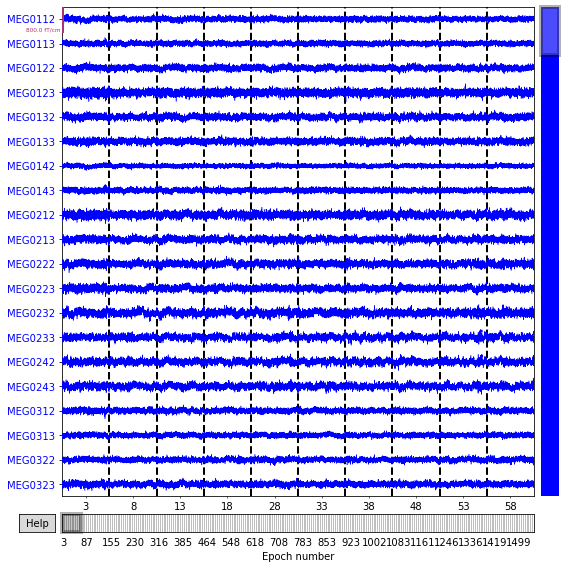

In [12]:
%matplotlib inline
epochs['left'].plot(n_epochs=10,picks=['grad'],event_id={'left':21});

The plot above shows 10 trials of type left; only gradiometers shown.

To show the trigger (stimulus channels) write:

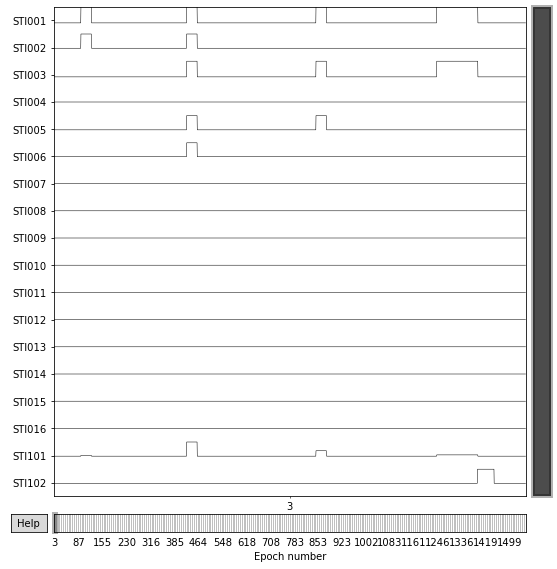

In [13]:
%matplotlib inline
epochs['left'].plot(n_epochs=1,picks=['stim'],event_id={'left': 21});

An example of the trigger channels for one trial.

Showing the trigger channels is often useful for verifying that correct trials have been selected. Note that STI001 to STI016 denote the individual trigger lines which are 'on' (1) or 'off' (0). The channel STI101 is a combination of the trigger lines ( STI101 = STI001 + 2 * STI002 + 4 * STI003 + 8 * STI004 + ...)

To show all the trials belonging to *left* for a representative gradiometer (MEG2343) use the plot_image function. In the following example we also lowpass filter the indvidual trials at 30 Hz and shorten them (crop) to a -100 to 400 ms interval:

Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 441 samples (0.441 sec)

Not setting metadata
Not setting metadata
130 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


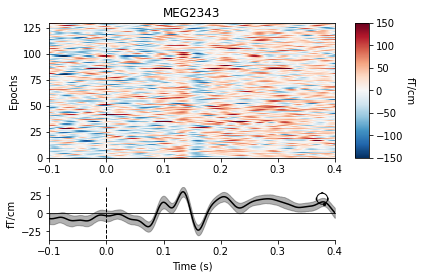

In [14]:
%matplotlib inline
epochs['left'].filter(0.0,30).crop(-0.1,0.4).plot_image(picks=['MEG2343'],vmin=-150,vmax=150);

## Preregistration and publications

Publication, example:

"The data were segmented into intervals of 4.5 s, ranging from 2.5 s prior to stimulus onset and 2 s after. To ensure that no artefacts were missed, trials in which the gradiometers values exceeded 5000 fT/cm or magnetometers exceeded 5000 fT were rejected as well as trials previously annotated with muscle artefacts."
